## Install the package dependencies before running this notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [37]:
!pip3 install pickle5
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./drive/MyDrive/CSE151BData/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_data(city, split, type):
    f = ROOT_PATH + split + "/" + city + "_" + type
    data = pickle.load(open(f, "rb"))
    data = np.asarray(data)
    return data

def get_city_trajectories(city="palo-alto", split="train"):
    if city != "all":
        inputs = get_data(city, split, "inputs")
    else:
        inputs = []
        for place in cities:
            inputs.append(get_data(place, split, "inputs"))
        inputs = np.concatenate(inputs, axis=0)
    
    outputs = None

    if split=="train":
        if city != "all":
            outputs = get_data(city, split, "outputs")
        else:
            outputs = []
            for place in cities:
                outputs.append(get_data(place, split, "outputs"))
            outputs = np.concatenate(outputs, axis=0)



        trajectories = np.concatenate((inputs, outputs), axis=1)
        trajectories = trajectories.reshape(-1, trajectories.shape[1], trajectories.shape[2])
        trajectories = trajectories.astype(np.float32)
            
        inputs = []
        outputs = []
        for trajectory in trajectories:
            inputs.append(trajectory[0:50])
            outputs.append(trajectory[1:51])

            inputs.append(trajectory[55:105])
            outputs.append(trajectory[56:106])
                

    inputs, outputs = np.asarray(inputs), np.asarray(outputs)
    print(inputs.shape, outputs.shape)
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str):
        super(ArgoverseDataset, self).__init__()
        self.city, self.split = city, split

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == "train":
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = (self.inputs[idx])

        return data
    

curr_city = cities[5]

# intialize each dataset
train_dataset = ArgoverseDataset(city=curr_city, split="train")
test_dataset = ArgoverseDataset(city=curr_city, split="test")

# Train Validation Split
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(23986, 50, 2) (23986, 50, 2)
(1686, 50, 2) ()


## Create a DataLoader class for training

In [38]:
batch_sz = 256  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz,shuffle=True)
val_loader = DataLoader(valid_dataset,batch_size=batch_sz,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1)


## Sample a batch of data and visualize 

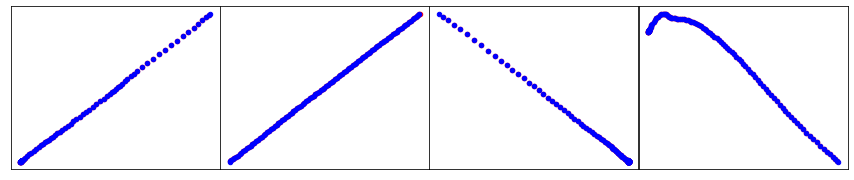

In [ ]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)

    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], c='r', s=20)
        axs[i].scatter(out[i,:,0], out[i,:,1], c='b', s=20)
    

for i_batch, sample_batch in enumerate(train_loader):
    if i_batch != 4: continue
    inputs, outputs = sample_batch
    show_sample_batch(sample_batch)
    break




## Create Model

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

from torch import nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=256, num_layers=1, bidirectional=False, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(256, 128)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(128, 2)

    def forward(self, x, h=None, c=None):
        offset =  x[:,-1,:].unsqueeze(1).repeat(1,x.size(1),1)
        x = x - offset
        if (h is not None) and (c is not None):
            x, (h, c) = self.lstm(x, (h, c))
        else:
            x, (h, c) = self.lstm(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = x + offset
        return x, h, c
        

Using device: cuda


## Train Model

In [40]:
num_epochs = 200
learning_rate = 0.001

lstm = LSTM()
lstm.to(device)
optimizer = torch.optim.Adam(lstm.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.25, verbose=True)
loss_fn = nn.L1Loss()

for epoch in range(1, num_epochs + 1, 1):
    lstm.train(True)
    for i_batch, sample_batch in enumerate(train_loader):
        inp, label = sample_batch
        
        inp = inp.to(device)
        label = label.to(device)
        output, h, c = lstm(inp.float())

        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0 and i_batch != 0:
            print(f"Epoch: {epoch}/{num_epochs}, Batch: {i_batch}/{len(train_loader)}, Loss: {loss.item()}")

    lstm.train(False)
    val_loss = 0
    with torch.no_grad():
        for i_batch, sample_batch in enumerate(val_loader):
            inp, label = sample_batch
            inp, label = inp.to(device), label.to(device)
            output, h, c = lstm(inp.float())
            loss = loss_fn(output, label)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    print(f"Epoch: {epoch}/{num_epochs}, Val Loss: {val_loss}")

if not os.path.exists("./models"):
    os.makedirs("./models")
f = (f"models/{curr_city}_model.pt")
torch.save(lstm.state_dict(), f)

        

Epoch: 1/200, Batch: 10/75, Loss: 11.434062004089355
Epoch: 1/200, Batch: 20/75, Loss: 9.944425582885742
Epoch: 1/200, Batch: 30/75, Loss: 9.543438911437988
Epoch: 1/200, Batch: 40/75, Loss: 8.91795539855957
Epoch: 1/200, Batch: 50/75, Loss: 8.099685668945312
Epoch: 1/200, Batch: 60/75, Loss: 7.835661888122559
Epoch: 1/200, Batch: 70/75, Loss: 6.947502136230469
Epoch: 1/200, Val Loss: 6.901064797451622
Epoch: 2/200, Batch: 10/75, Loss: 5.964587211608887
Epoch: 2/200, Batch: 20/75, Loss: 5.993321418762207
Epoch: 2/200, Batch: 30/75, Loss: 6.188864707946777
Epoch: 2/200, Batch: 40/75, Loss: 6.148017883300781
Epoch: 2/200, Batch: 50/75, Loss: 5.370297908782959
Epoch: 2/200, Batch: 60/75, Loss: 5.336132049560547
Epoch: 2/200, Batch: 70/75, Loss: 4.971832752227783
Epoch: 2/200, Val Loss: 4.909296788667378
Epoch: 3/200, Batch: 10/75, Loss: 4.3895792961120605
Epoch: 3/200, Batch: 20/75, Loss: 4.119877338409424
Epoch: 3/200, Batch: 30/75, Loss: 4.590049743652344
Epoch: 3/200, Batch: 40/75, Los

## Load Model

In [41]:
f = (f"models/{curr_city}_model.pt")
lstm = LSTM()
lstm.load_state_dict(torch.load(f, map_location=device))
lstm.to(device)
lstm.train(False)

LSTM(
  (lstm): LSTM(2, 256, batch_first=True)
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=128, out_features=2, bias=True)
)

## Validation Data Output

In [42]:
validation_outputs = []
for i_batch, sample_batch in enumerate(val_loader):
    inp, label = sample_batch
    inp = inp.to(device)
    output, h, c = lstm(inp.float())
    validation_outputs.append((inp.cpu().numpy(), output.detach().cpu().numpy(), label))

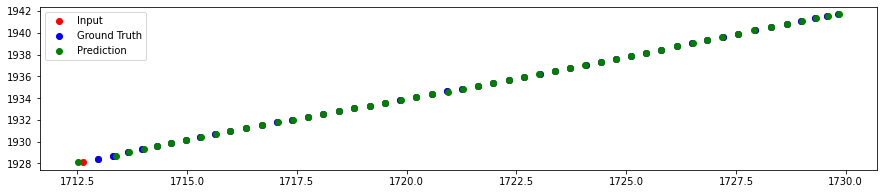

In [45]:
import matplotlib.pyplot as plt
# Plot the validation results     
data = validation_outputs[3]
inp, output, label = data
plt.figure(figsize=(15, 3))
plt.scatter(inp[0,:,0], inp[0,:,1], c='r', label="Input")
plt.scatter(label[0,:,0], label[0,:,1], c='b', label="Ground Truth")
plt.scatter(output[0,:,0], output[0,:,1], c='g', label="Prediction")
plt.legend()
plt.show()

## Sample Function

In [46]:
def sample(x, model, steps=60):
    final_output = x
    for i in range(steps):
        model_output, h, c = model(final_output)
        elem = model_output[:, -1, :].unsqueeze(1)
        final_output = torch.cat((final_output, elem), dim=1)
    return final_output[:, 50:, :]

## Make Prediction

0/1686
10/1686
20/1686
30/1686
40/1686
50/1686
60/1686
70/1686
80/1686
90/1686
100/1686
110/1686
120/1686
130/1686
140/1686
150/1686
160/1686
170/1686
180/1686
190/1686
200/1686
210/1686
220/1686
230/1686
240/1686
250/1686
260/1686
270/1686
280/1686
290/1686
300/1686
310/1686
320/1686
330/1686
340/1686
350/1686
360/1686
370/1686
380/1686
390/1686
400/1686
410/1686
420/1686
430/1686
440/1686
450/1686
460/1686
470/1686
480/1686
490/1686
500/1686
510/1686
520/1686
530/1686
540/1686
550/1686
560/1686
570/1686
580/1686
590/1686
600/1686
610/1686
620/1686
630/1686
640/1686
650/1686
660/1686
670/1686
680/1686
690/1686
700/1686
710/1686
720/1686
730/1686
740/1686
750/1686
760/1686
770/1686
780/1686
790/1686
800/1686
810/1686
820/1686
830/1686
840/1686
850/1686
860/1686
870/1686
880/1686
890/1686
900/1686
910/1686


KeyboardInterrupt: ignored

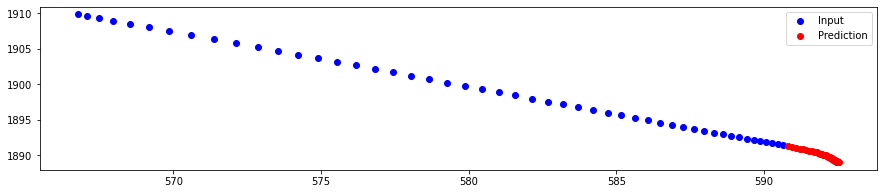

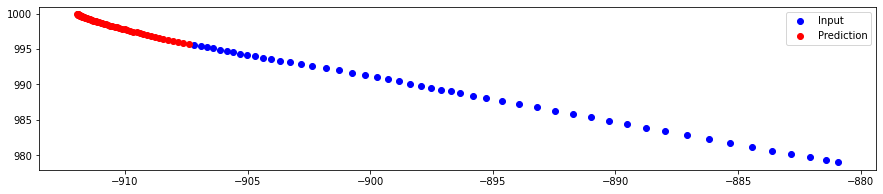

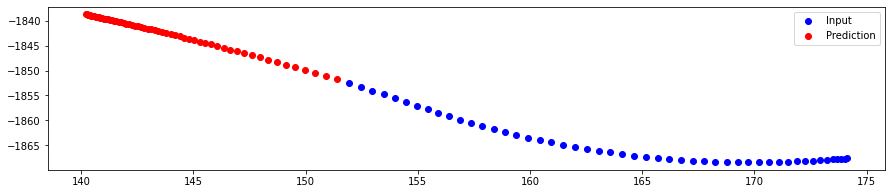

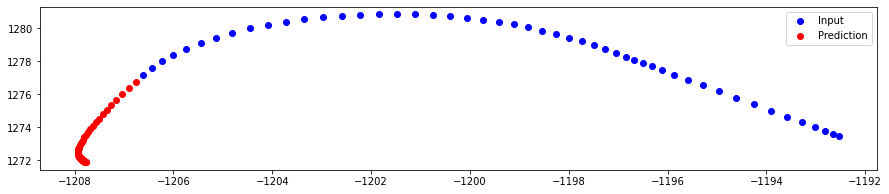

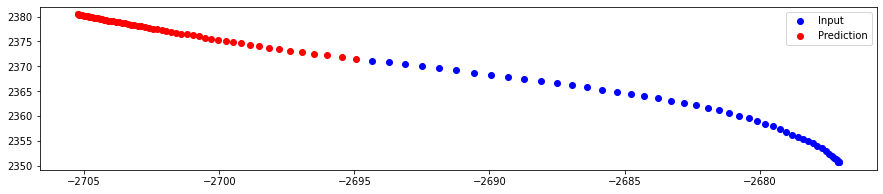

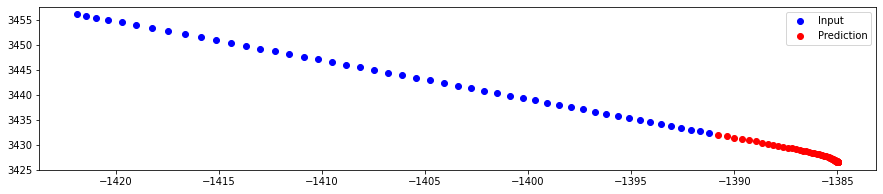

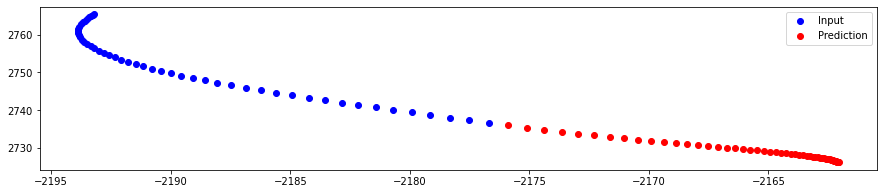

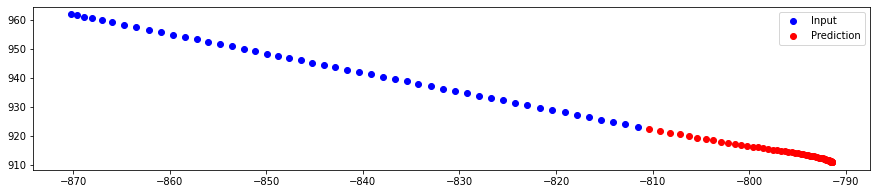

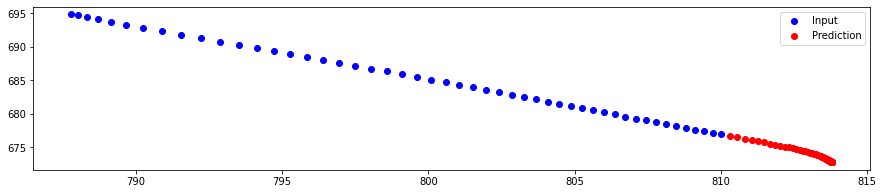

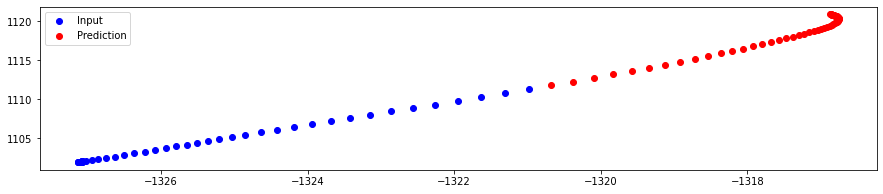

In [47]:
f = f"{curr_city}_trajectory.csv"

with open(f, "w") as f:
    for i, inp in enumerate(test_loader):
        inp = inp.to(device)
        inp = inp.float()
        output = sample(inp, lstm)

        inp = inp.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        output = output.squeeze()

        if i % 100 == 0:
            plt.figure(figsize=(15, 3))
            plt.scatter(inp[0,:,0], inp[0,:,1], c='b', label="Input")
            plt.scatter(output[:,0], output[:,1], c='r', label="Prediction")
            plt.legend()
            plt.savefig(f"{curr_city}_trajectory_{i}.png")

        f.write(f"{i}_{curr_city}")
        for pos in output:
            f.write(f",{pos[0]},{pos[1]}")
        f.write("\n")
        if i % 10 == 0:
            print(f"{i}/{len(test_loader)}")
        
